In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
import heapq
import warnings
import math
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
genome_scores_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\genome_scores.csv')
genome_tags_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\genome_tags.csv')
imdb_data_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\imdb_data.csv')
links_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\links.csv')
movies_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\movies.csv')
sample_submission_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\sample_submission.csv')
tags_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\tags.csv')
test_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\test.csv')
train_df = pd.read_csv(r'C:\Users\matthew\Dropbox\Personal\Data Science Course\Unsupervised Learning\Predict\Data\train.csv')

In [7]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [9]:
train_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [10]:
train_df.drop(['timestamp'], axis = 1, inplace = True)
train_df.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


Average rating in dataset: 3.5333951730983424


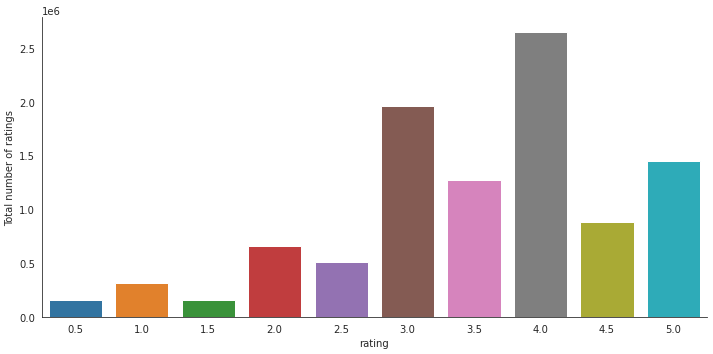

In [11]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=train_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(train_df["rating"])}')

In [12]:
sample_submission_df.tail(100)

,Id,rating
4999919,162537_2384,1.0
4999920,162537_2496,1.0
4999921,162537_2617,1.0
4999922,162537_3258,1.0
4999923,162537_4022,1.0
...,...,...
5000014,162541_4079,1.0
5000015,162541_4467,1.0
5000016,162541_4980,1.0
5000017,162541_5689,1.0


In [13]:
# number of ratings
len(train_df['rating'])

10000038

In [14]:
# number of users
len(train_df['userId'].unique())

162541

In [15]:
# number of unique movie id's
len(train_df['movieId'].unique())

48213

In [16]:
# average number of movie ratings per user
ratings_per_user = train_df.groupby('userId')['rating'].count()
np.mean(ratings_per_user.to_list())

61.52317261490947

<AxesSubplot:>

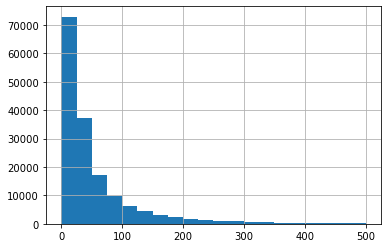

In [17]:
# distribution of ratings per user
ratings_per_user.hist(bins = 20, range = (0,500))

In [18]:
# avg number of ratings per movie id
ratings_per_movie = train_df.groupby('movieId')['rating'].count()
np.mean(ratings_per_movie.tolist())

207.41372658826458

<AxesSubplot:>

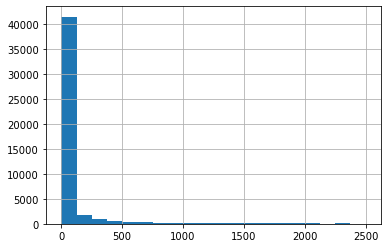

In [19]:
# distribution of ratings per movie id
ratings_per_movie.hist(bins=20, range=(0,2500))

In [20]:
sample_df = train_df.sample(n=50000, random_state = 2022)

In [21]:
pvt_table = pd.pivot_table(sample_df, values = 'rating', columns = 'movieId', index = 'userId', fill_value = '0')
pvt_table

movieId,1,2,3,4,5,6,7,8,9,10,...,204698,204868,205026,205297,205449,205513,205523,206208,206499,207405
userId,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
pvt_table = pvt_table.T

In [23]:
user_similarity = cosine_similarity(pvt_table.T)
user_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
user_sim_df = pd.DataFrame(user_similarity,
                          index = pvt_table.columns,
                          columns = pvt_table.columns)
user_sim_df

userId,3,4,5,8,12,18,19,20,21,23,...,162488,162495,162498,162501,162508,162516,162519,162534,162538,162541
userId,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.596285,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162516,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
162519,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
162534,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
test_df.head()

,userId,movieId
0,5,788
1,68,7438
2,336,40412
3,803,3822
4,547,903


In [26]:
test_user = 59
test_movie = 2139
k = 10
sorted_users = pd.DataFrame(user_sim_df.loc[:,test_user]).sort_values(by = test_user, ascending = False)
most_similar_users = sorted_users.drop(sorted_users.iloc[0:])
n_most_similar_users = most_similar_users[:k]
n_most_similar_users

,59
userId,
2711,1.0
56171,1.0
21635,1.0
127662,1.0
55560,1.0
133616,1.0
113437,1.0
107665,1.0
30456,1.0


In [27]:
test_movie

2139

In [28]:
most_similar_user_ratings = pd.DataFrame(pvt_table.loc[test_movie,n_most_similar_users.index])
most_similar_user_ratings

,2139
userId,
2711,0
56171,0
21635,0
127662,0
55560,0
133616,0
113437,0
107665,0
30456,0


In [29]:
new_df = n_most_similar_users.merge(most_similar_user_ratings,
                                    on='userId',
                                    how='left').rename(columns = {test_user:'user_similarity',
                                                                  test_movie:'movie_rating'})
new_df

,user_similarity,movie_rating
userId,,
2711,1.0,0
56171,1.0,0
21635,1.0,0
127662,1.0,0
55560,1.0,0
133616,1.0,0
113437,1.0,0
107665,1.0,0
30456,1.0,0


In [30]:
new_df['movie_rating'] = new_df['movie_rating'].astype(float)
new_df

,user_similarity,movie_rating
userId,,
2711,1.0,0.0
56171,1.0,0.0
21635,1.0,0.0
127662,1.0,0.0
55560,1.0,0.0
133616,1.0,0.0
113437,1.0,0.0
107665,1.0,0.0
30456,1.0,0.0


In [31]:
new_df['similarity_x_rating'] = new_df['user_similarity'] * new_df['movie_rating']
new_df

,user_similarity,movie_rating,similarity_x_rating
userId,,,
2711,1.0,0.0,0.0
56171,1.0,0.0,0.0
21635,1.0,0.0,0.0
127662,1.0,0.0,0.0
55560,1.0,0.0,0.0
133616,1.0,0.0,0.0
113437,1.0,0.0,0.0
107665,1.0,0.0,0.0
30456,1.0,0.0,0.0


In [32]:
user_rating = round(new_df['similarity_x_rating'].sum() / new_df['user_similarity'].sum() * 2) / 2
user_rating

0.0

In [33]:
avg_rating_per_movie = train_df.groupby('movieId').mean()
avg_global_rating_per_ref_movie = round(avg_rating_per_movie.loc[test_movie,'rating'] * 2) / 2
avg_global_rating_per_ref_movie

3.5

In [34]:
avg_rating_per_user = train_df.groupby('userId').mean()
avg_user_rating = round(avg_rating_per_user.loc[test_user,'rating'] * 2) / 2
avg_user_rating

3.5

In [68]:
test_df.head(10)

,userId,movieId
0,5,788
1,68,7438
2,336,40412
3,803,3822
4,547,903
5,514,5379
6,367,190939
7,345,3007
8,468,5782
9,441,2908


In [60]:
sample_users = pd.DataFrame(user_sim_df.index)
sample_movies = pd.DataFrame(pvt_table.index)    

In [63]:
sample_users.head(10)

,userId
0,3
1,4
2,5
3,8
4,12
5,18
6,19
7,20
8,21
9,23


In [100]:
sample_movies.head()

,movieId
0,1
1,2
2,3
3,4
4,5


In [79]:
def lookup(x,y):
    if x in sample_users['userId'].values:
        print("True")
    else:
        print("False")
        
    if y in sample_movies['movieId'].values:
        print("True")
    else:
        print("False")

In [204]:
#Test 0
#Test for when both Reference User & Reference Movie = True
lookup(21,788)

True
True


In [196]:
#Test 1
#Test for Reference User = True & Reference Movie = False
#Should return the avg_user_rating
lookup(18,207404)

True
False


In [91]:
#Test 2
#Test for Reference User = False & Reference Movie = True
#Should return the average_global_rating_per_ref_movie
lookup(2,1213)

False
True


In [94]:
#Test 3
#Test for Reference User = False & Reference Movie = False
#Should return the overall_global_movie_rating
lookup(2,207404)

False
False


In [105]:
#Test 1
avg_rating_per_user = train_df.groupby('userId').mean()
avg_user_rating = round(avg_rating_per_user.loc[21,'rating'] * 2) / 2
avg_user_rating

4.5

In [96]:
#Test 2
avg_rating_per_movie = train_df.groupby('movieId').mean()
avg_global_rating_per_ref_movie = round(avg_rating_per_movie.loc[1213,'rating'] * 2) / 2
avg_global_rating_per_ref_movie

4.0

In [98]:
#Test 3
overall_global_movie_rating = round(train_df['rating'].mean() * 2) / 2
overall_global_movie_rating

3.5

In [214]:
def user_movie_rating_prediction(reference_user, reference_movie):
    
    #Defining the number of similar users to use from the similarity matrix
    k = 10
    
    #Isolating the sample users and sample movies for easy reference. These are the users in the similarity table and the movies in the sampled pivot table
    sample_users = pd.DataFrame(user_sim_df.index)
    sample_movies = pd.DataFrame(pvt_table.index)
    
    if reference_user not in sample_users['userId'].values:
        
        #Defining the overall average rating for a reference movie from the training dataset
        avg_rating_per_movie = train_df.groupby('movieId').mean()
        avg_global_rating_per_ref_movie = round(avg_rating_per_movie.loc[reference_movie,'rating'] * 2) / 2

        return avg_global_rating_per_ref_movie

    elif reference_movie not in sample_movies['movieId'].values:
        #Defining the overall average rating for a reference user from the training dataset
        avg_rating_per_user = train_df.groupby('userId').mean()
        avg_user_rating = round(avg_rating_per_user.loc[reference_user,'rating'] * 2) / 2

        return avg_user_rating

    elif reference_user not in sample_users['userId'].values:
        if reference_movie not in sample_movies['movieId'].values:
            if reference_movie in train_df['movieId'].values:
                
                return avg_global_rating_per_ref_movie
            
            elif reference_user in train_df['userId'].values:
                
                return avg_user_rating
            
            elif reference_user not in train_df['userId'].values and reference_movie not in train_df['movieId'].values:
                
                #Defining the overall global average ratings of ALL movies in the training dataset
                overall_global_movie_rating = round(train_df['rating'].mean() * 2) / 2

                return overall_global_movie_rating 
     
    else:
            
        #Defining how to determine a user rating based on the weighted average of similar users for a reference user in the similarity matrix
        sorted_users = pd.DataFrame(user_sim_df.loc[:,reference_user]).sort_values(by = reference_user, ascending = False) #Ranking similar users
        most_similar_users = sorted_users.drop(sorted_users.iloc[0:]) #droping the reference user
        n_most_similar_users = most_similar_users[:k] #defining the kth number of similar users
        most_similar_user_ratings = pd.DataFrame(pvt_table.loc[reference_movie,n_most_similar_users.index]) #Compiling the ratings of the reference movie that each similar user rated that movie

        #Joining the tables to create a new df to calculate weighted average rating per reference user and reference movie combination
        new_df = n_most_similar_users.merge(most_similar_user_ratings, on='userId', how='left').rename(columns = {reference_user:'user_similarity',
                                                                                                                  reference_movie:'movie_rating'})
        new_df['movie_rating'] = new_df['movie_rating'].astype(float) #changing the data type from an object to a float to work mathemaically

        #Defining the user rating
        new_df['similarity_x_rating'] = new_df['user_similarity'] * new_df['movie_rating']
        user_rating = round(new_df['similarity_x_rating'].sum() / new_df['user_similarity'].sum() * 2) / 2

        return user_rating
    

In [215]:
user_movie_rating_prediction(2,1213)

4.0

In [57]:
rating_list = []

for reference_user, reference_movie in test_df.iterrows():
    reference_user = test_df['userId']
    reference_movie = test_df['movieId']
        
    rating = user_movie_rating_prediction(reference_user, reference_movie)
    
    rating_list.append([reference_user, reference_movie, rating])
    

ValueError: ('Lengths must match to compare', (14310,), (34233,))

List of things to still check and confirm:
 - Manually check to see if the similar users identified definitely didn't rate the movie in question
 - Figure out how to in the if statement correctly lookup up the reference user to get a proper True or False so the next elif or else can check and return
 - figure out the for loop on how to apply the test_df to the function for each ref_user and ref_movie and save the rating and add to a test file so I can alter the format and use this for my submission

In [134]:
#Nested If Statement Test
#Creating dummy df
dummy_df = train_df[:10]
dummy_df

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0
5,120949,81768,3.0
6,19630,62049,4.0
7,21066,2282,1.0
8,117563,120474,4.0
9,144018,1997,5.0


In [166]:
a = 5163
b = 57669

In [169]:
def test_function(a,b):

    if a in dummy_df['userId'].values:
        if b in dummy_df['movieId'].values:

            avg_rating_per_user = train_df.groupby('userId').mean()
            avg_user_rating = round(avg_rating_per_user.loc[a,'rating'] * 2) / 2

            return avg_user_rating

    else:
        #Defining the overall global average ratings of ALL movies in the training dataset
        overall_global_movie_rating = round(train_df['rating'].mean() * 2) / 2

        return overall_global_movie_rating

In [170]:
test_function(a,b)

4.0

In [ ]:
if reference user not in sample users:
    

else:
    #reference user is in the sample users
    